Attempt 1

Targets: Define a skeleton, Make a model and use BatchNorm
Results:


Parameters: 14,536

Train Acc: 99.88%

Test Acc: 99.21%

Analysis:

The model is overfitting as train accuracy is almost close to 100% so no room for improvement
Need a smaller model with bit of regularisation

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
if torch.backends.mps.is_available():
    # Apple Silicon GPU
    device = "mps"
    use_cuda = True
elif torch.cuda.is_available():
    # nVidia GPU
    device = "cuda"
    use_cuda = True
else:
    # CPU
    device = "cpu"

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

# Test Phase transformations
test_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [5]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if use_cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [6]:

from tqdm import tqdm


def train_model(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test_model(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
def plot(train_losses, test_losses, train_acc, test_acc):
    t = [t_items.item() for t_items in train_losses]
    %matplotlib inline
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")


In [7]:
from models import Model_1

In [8]:
!pip install torchsummary
from torchsummary import summary

# run summary on cpu first then shift to device
model = Model_1().to("cpu")
summary(model, input_size=(1, 28, 28))


print("Running models on: ", device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
            Conv2d-4           [-1, 16, 24, 24]           2,304
              ReLU-5           [-1, 16, 24, 24]               0
       BatchNorm2d-6           [-1, 16, 24, 24]              32
            Conv2d-7           [-1, 16, 22, 22]           2,304
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,304
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Conv2d-14             [-1, 1

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]

Loss=0.02243204601109028 Batch_id=468 Accuracy=94.59: 100%|██████████| 469/469 [00:09<00:00, 51.90it/s] 



Test set: Average loss: 0.0461, Accuracy: 9867/10000 (98.67%)

EPOCH: 1


Loss=0.04538055136799812 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:07<00:00, 62.69it/s]  



Test set: Average loss: 0.0423, Accuracy: 9873/10000 (98.73%)

EPOCH: 2


Loss=0.03986293449997902 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:07<00:00, 63.07it/s]  



Test set: Average loss: 0.0331, Accuracy: 9888/10000 (98.88%)

EPOCH: 3


Loss=0.01104289572685957 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:07<00:00, 61.94it/s]  



Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.019463634118437767 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:07<00:00, 61.94it/s] 



Test set: Average loss: 0.0291, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.0546201653778553 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:07<00:00, 60.44it/s]   



Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 6


Loss=0.021717170253396034 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:08<00:00, 56.37it/s] 



Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.012639769352972507 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:07<00:00, 59.89it/s]  



Test set: Average loss: 0.0284, Accuracy: 9911/10000 (99.11%)

EPOCH: 8


Loss=0.002452851040288806 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:08<00:00, 54.83it/s] 



Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)

EPOCH: 9


Loss=0.005985523108392954 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:08<00:00, 57.69it/s]  



Test set: Average loss: 0.0281, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.000893360294867307 Batch_id=468 Accuracy=99.72: 100%|██████████| 469/469 [00:08<00:00, 57.74it/s]  



Test set: Average loss: 0.0265, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.014363601803779602 Batch_id=468 Accuracy=99.75: 100%|██████████| 469/469 [00:08<00:00, 57.71it/s]  



Test set: Average loss: 0.0247, Accuracy: 9920/10000 (99.20%)

EPOCH: 12


Loss=0.016600947827100754 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:08<00:00, 55.94it/s]  



Test set: Average loss: 0.0251, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.0701957419514656 Batch_id=468 Accuracy=99.83: 100%|██████████| 469/469 [00:07<00:00, 59.16it/s]    



Test set: Average loss: 0.0293, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.002923161955550313 Batch_id=468 Accuracy=99.88: 100%|██████████| 469/469 [00:08<00:00, 54.90it/s]  



Test set: Average loss: 0.0281, Accuracy: 9913/10000 (99.13%)



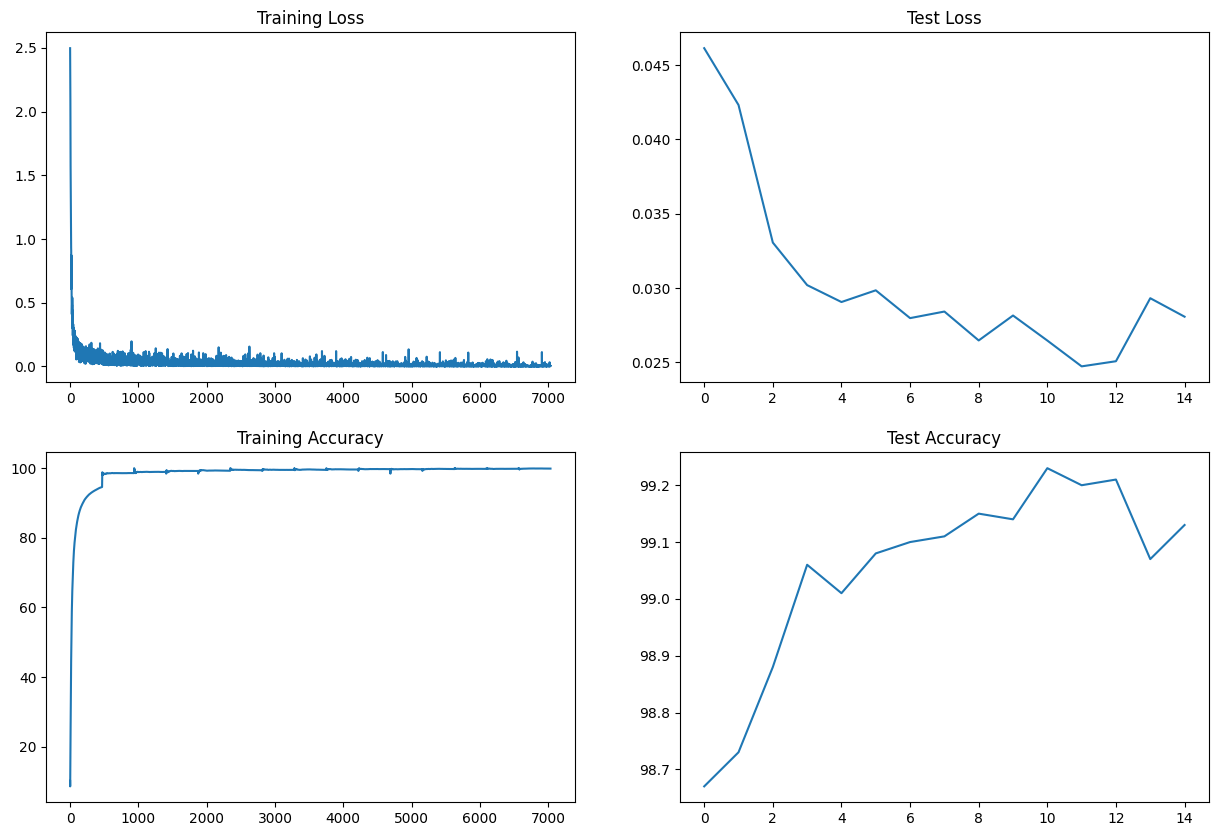

In [9]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []
model =  Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_model(model, device, train_loader, optimizer, epoch)
    test_model(model, device, test_loader)
plot(train_losses, test_losses, train_acc, test_acc)